In [1]:
import torch as t

import torch.nn as nn

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('prices-split-adjusted.csv')

df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
df = df[df.symbol == 'GOOGL']
df.index = df.date

df.drop(columns = ['date', 'symbol'], inplace = True)

In [4]:
df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,313.788792,313.688694,312.432438,315.070073,3908400.0
2010-01-05,313.903904,312.307316,311.081089,314.234226,6003300.0
2010-01-06,313.243260,304.434452,303.483494,313.243260,7949400.0
2010-01-07,305.005009,297.347355,296.621617,305.305302,12815700.0
2010-01-08,296.296299,301.311314,294.849857,301.926945,9439100.0


In [5]:
df_target = df[['close']]

df_target.head()

,close
date,
2010-01-04,313.688694
2010-01-05,312.307316
2010-01-06,304.434452
2010-01-07,297.347355
2010-01-08,301.311314


In [6]:
MMS_x = MinMaxScaler()
MMS_y = MinMaxScaler()

df = MMS_x.fit_transform(df.values)
df_target = MMS_y.fit_transform(df_target.values)

In [7]:
df = pd.DataFrame(df, columns = ['open', 'close', 'low', 'high','volume'])

df.head()

,open,close,low,high,volume
0,0.152496,0.154555,0.155881,0.151721,0.116422
1,0.152682,0.152318,0.153673,0.150368,0.188413
2,0.151615,0.139568,0.141259,0.148763,0.255291
3,0.138309,0.128090,0.130047,0.135911,0.422522
4,0.124243,0.134510,0.127152,0.130441,0.306485


In [8]:
df_target = pd.DataFrame(df_target, columns = ['close'])

df_target.head()

,close
0,0.154555
1,0.152318
2,0.139568
3,0.128090
4,0.134510


In [9]:
df.drop('close', axis = 1, inplace = True)

In [10]:
df['close'] = df_target.close

In [45]:
df.head()

,open,low,high,volume,close
0,0.152496,0.155881,0.151721,0.116422,0.154555
1,0.152682,0.153673,0.150368,0.188413,0.152318
2,0.151615,0.141259,0.148763,0.255291,0.139568
3,0.138309,0.130047,0.135911,0.422522,0.128090
4,0.124243,0.127152,0.130441,0.306485,0.134510


In [61]:
def make_dataset(df, seq_len, train_size = 0.9):
    feature = df.shape[1]
    x_value = df.values
    sequence_len = seq_len + 1
    data = []
    
    for i in range(len(x_value) - sequence_len):
        data.append(x_value[i : i + sequence_len])
        
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    
    train_data = data[:train_split]
    test_data = data[train_split:]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:, -1]
    
    x_test = test_data[:, :-1]
    y_test = test_data[:, -1][:, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], feature))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], feature))
    
    return x_train, y_train, x_test, y_test

In [62]:
x_train, y_train, x_test, y_test = make_dataset(df, 24)

In [63]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1563, 24, 5), (1563,), (174, 24, 5), (174,))

In [ ]:
batch_size = 1

input_size = x_train.shape[2] 

output_size = 1

In [16]:
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          1, 
                          x_train.shape[2])

In [17]:
x_test = x_test.reshape(x_test.shape[0],
                        x_test.shape[1],
                        1,
                        x_test.shape[2])

In [18]:
x_test = t.tensor(x_test)
y_test = t.tensor(y_test)

In [19]:
x_train = t.tensor(x_train)
y_train = t.tensor(y_train)

In [20]:
x_train.shape, y_train.shape

(torch.Size([1563, 24, 1, 5]), torch.Size([1563]))

In [23]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, n_layer, batch_size):
        
        super(LSTM_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_hidden = n_hidden
        self.n_layer = n_layer
        self.batch_size = batch_size
        
        
        self.lstm = nn.LSTM(input_size, n_hidden, n_layer)
        
        
        self.linear = nn.Linear(n_hidden, output_size)
        
    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)
        
        out = output
        
        out = out.view(len(x), -1)
        
        out = self.linear(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layer,
                             batch_size,
                             self.n_hidden).zero_().to(device),
                  weight.new(self.n_layer,
                             batch_size,
                             self.n_hidden).zero_().to(device)
                 )
        
        return hidden

In [24]:
n_hidden = 128
n_layer = 1
lr = 0.0001

model = LSTM_Model(input_size, output_size, n_hidden, n_layer, batch_size)

print(model)

LSTM_Model(
  (lstm): LSTM(5, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [25]:
optimizer = t.optim.Adam(model.parameters(), lr = lr)
cri = nn.MSELoss()
device = t.device("cuda" if t.cuda.is_available() else "cpu")

device

device(type='cuda')

In [26]:
model = model.float()
x_train = x_train.float()
y_train = y_train.float()
x_test = x_test.float()
y_test = y_test.float()

In [27]:
n_epoch = 150

In [28]:
model.train()

model = model.to(device)

train_loss = []
mean_train_loss = []
x_train_pred = []

for Epoch in range(n_epoch):
    hidden_cells = model.init_hidden(batch_size)
    
    for i in range(len(x_train)):
        
        hidden_cells = tuple([e.data for e in hidden_cells])
        
        optimizer.zero_grad()
        
        x = x_train[i]
        y = y_train[i]
        x = x.to(device)
        y = y.to(device)
        
        
        y_pred, hidden_cells = model(x, hidden_cells)
        x_train_pred.append(y_pred)
        
        loss = cri(y_pred[-1], y.unsqueeze(0))
        train_loss.append(loss.item())
        loss.backward()
        
        optimizer.step()
        
        model.train()
        mean_loss = np.mean(train_loss)
        mean_train_loss.append(mean_loss)
        
    if Epoch % 10 == 0:
        print('Epoch: {}/{}'.format(Epoch, n_epoch))
        print('Training Loss {:.4f}'.format(loss.item()))

Epoch: 0/150
Training Loss 0.0054
Epoch: 10/150
Training Loss 0.0044
Epoch: 20/150
Training Loss 0.0042
Epoch: 30/150
Training Loss 0.0042
Epoch: 40/150
Training Loss 0.0040
Epoch: 50/150
Training Loss 0.0040
Epoch: 60/150
Training Loss 0.0039
Epoch: 70/150
Training Loss 0.0038
Epoch: 80/150
Training Loss 0.0039
Epoch: 90/150
Training Loss 0.0041
Epoch: 100/150
Training Loss 0.0040
Epoch: 110/150
Training Loss 0.0039
Epoch: 120/150
Training Loss 0.0039
Epoch: 130/150
Training Loss 0.0039
Epoch: 140/150
Training Loss 0.0040


In [29]:
pred = []
model.eval()
model = model.to(device)

hidden_cells = model.init_hidden(batch_size)
for i in range(len(x_test)):
    
    hidden_cells = tuple([e.data for e in hidden_cells])
    
    x = x_test[i]
    y = y_test[i]
    x = x.to(device)
    y = y.to(device)
    
    y_pred, hidden_cells = model(x, hidden_cells)
    
    pred.append(y_pred[-1].item())

In [31]:
actual = MMS_y.inverse_transform(y_test.reshape(-1, 1))

In [32]:
pred = MMS_y.inverse_transform(np.array(pred).reshape(-1, 1))

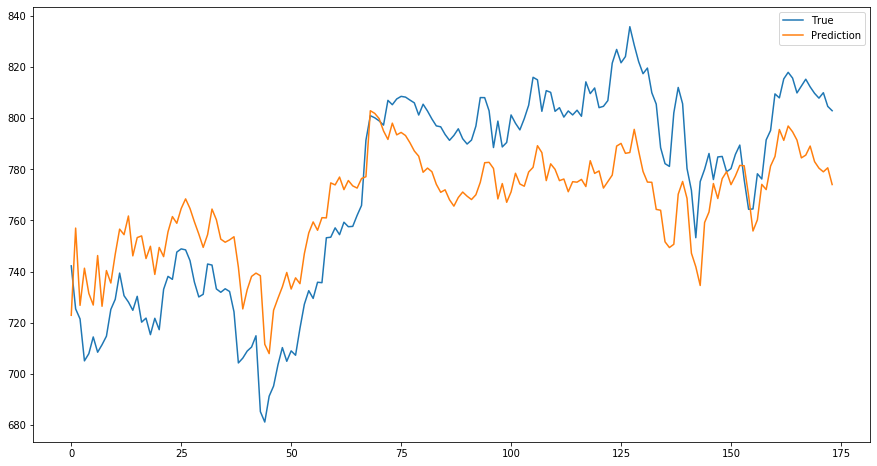

In [33]:
plt.figure(figsize = (15, 8))
plt.plot(actual, label = 'True')
plt.plot(pred, label = 'Prediction')
plt.legend()

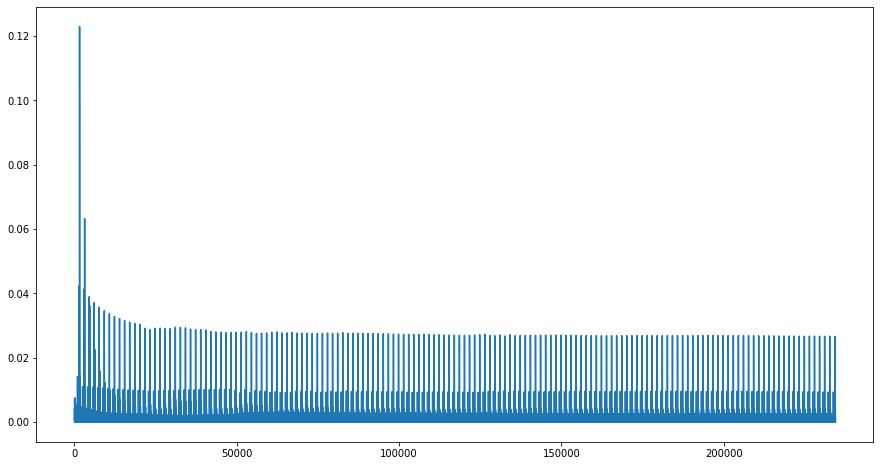

In [86]:
plt.figure(figsize = (15, 8))
plt.plot(train_loss)

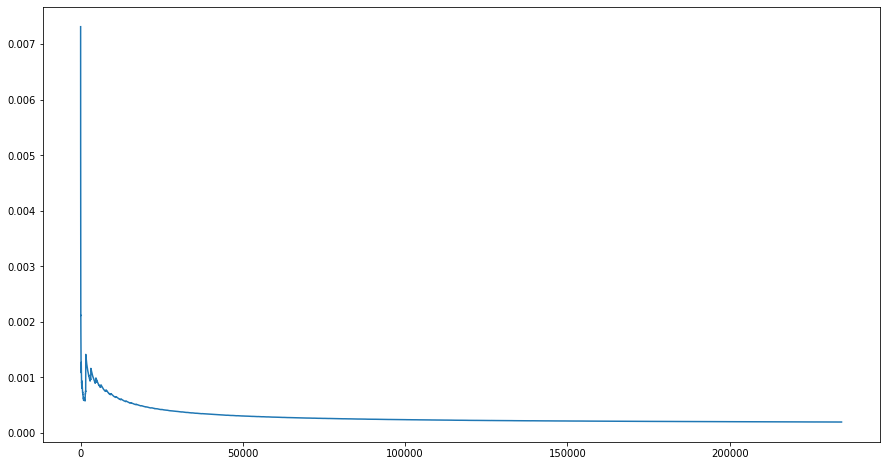

In [87]:
plt.figure(figsize = (15, 8))
plt.plot(mean_train_loss)